In [1]:
pip install featurewiz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from featurewiz import featurewiz
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import prediction_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [3]:
base_path = '/kaggle/input/self-reported-qol/20230625-processed-'

df_physical      = pd.read_csv(base_path + 'physical-qol.csv')
df_psychological = pd.read_csv(base_path + 'psychological-qol.csv')

df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day
df_psychological.drop('id', axis=1, inplace=True)    # id
df_psychological.drop('day', axis=1, inplace=True)   # day

phy_all_tmp = df_physical.copy()
phy_init_set_tmp = phy_all_tmp.query("group in ('Initial Set')").copy()
phy_ufpi_ufc_tmp = phy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

psy_all_tmp = df_psychological.copy()
psy_init_set_tmp = psy_all_tmp.query("group in ('Initial Set')").copy()
psy_ufpi_ufc_tmp = psy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

phy_all_tmp.drop("group", axis=1, inplace=True)
phy_init_set_tmp.drop("group", axis=1, inplace=True)
phy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

psy_all_tmp.drop("group", axis=1, inplace=True)
psy_init_set_tmp.drop("group", axis=1, inplace=True)
psy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

# Separating predictors from the values to be predicted.
phy_all           = phy_all_tmp.drop("phy_ref_score", axis=1)
phy_all_pred      = phy_all_tmp["phy_ref_score"].copy()
phy_init_set      = phy_init_set_tmp.drop("phy_ref_score", axis=1)
phy_init_set_pred = phy_init_set_tmp["phy_ref_score"].copy()
phy_ufpi_ufc      = phy_ufpi_ufc_tmp.drop("phy_ref_score", axis=1)
phy_ufpi_ufc_pred = phy_ufpi_ufc_tmp["phy_ref_score"].copy()

psy_all           = psy_all_tmp.drop("psy_ref_score", axis=1)
psy_all_pred      = psy_all_tmp["psy_ref_score"].copy()
psy_init_set      = psy_init_set_tmp.drop("psy_ref_score", axis=1)
psy_init_set_pred = psy_init_set_tmp["psy_ref_score"].copy()
psy_ufpi_ufc      = psy_ufpi_ufc_tmp.drop("psy_ref_score", axis=1)
psy_ufpi_ufc_pred = psy_ufpi_ufc_tmp["psy_ref_score"].copy()

In [4]:
def getDataset(domain_group):
    return {
        'phy_all': (phy_all, phy_all_pred),
        'psy_all': (psy_all, psy_all_pred),
        
        'phy_init_set': (phy_init_set, phy_init_set_pred),
        'psy_init_set': (psy_init_set, psy_init_set_pred),
        
        'phy_ufpi_ufc': (phy_ufpi_ufc, phy_ufpi_ufc_pred),
        'psy_ufpi_ufc': (psy_ufpi_ufc, psy_ufpi_ufc_pred),
    }[domain_group]

In [5]:
def get_rforest_phy():
    #skb = SelectKBest(score_func=mutual_info_regression, k = 70)
    skb = SelectKBest(score_func=mutual_info_regression, k = 'all')
    alg = RandomForestRegressor(warm_start=False, n_estimators=894, min_samples_split=5, min_samples_leaf=2, max_features=1.0, max_depth=10, criterion='squared_error', bootstrap=True, random_state=42)
    return Pipeline([('regressor', alg)])

In [6]:
def get_rforest_psy():
    skb = SelectKBest(score_func=mutual_info_regression, k = 50)
    alg = RandomForestRegressor(warm_start=False, n_estimators=1778, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, criterion='poisson', bootstrap=False, random_state=42)
    return Pipeline([('transformer', StandardScaler()), ('feat_selection', skb), ('regressor', alg)])

In [7]:
def rmsle_cv(model, domain_group, features):
    start = time.time()
    
    X, y = getDataset(domain_group)
    X = X.filter(features)
    
    kf = KFold(10, shuffle = True, random_state = 42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring = "neg_mean_squared_error", cv = kf))
    mae  = -cross_val_score(model, X.values, y, scoring = "neg_mean_absolute_error", cv = kf)
    r2 = cross_val_score(model, X.values, y, scoring = "r2", cv = kf)
    
    end = time.time()
    exec_time = end - start

    print('Time:', exec_time, 'MAE:', round(mae.mean(), 4), 'RMSE:',  round(rmse.mean(), 4), 'R^2:', round(r2.mean(), 4), '\n')

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (1373, 88)
    Some column names had special characters which were removed...
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  

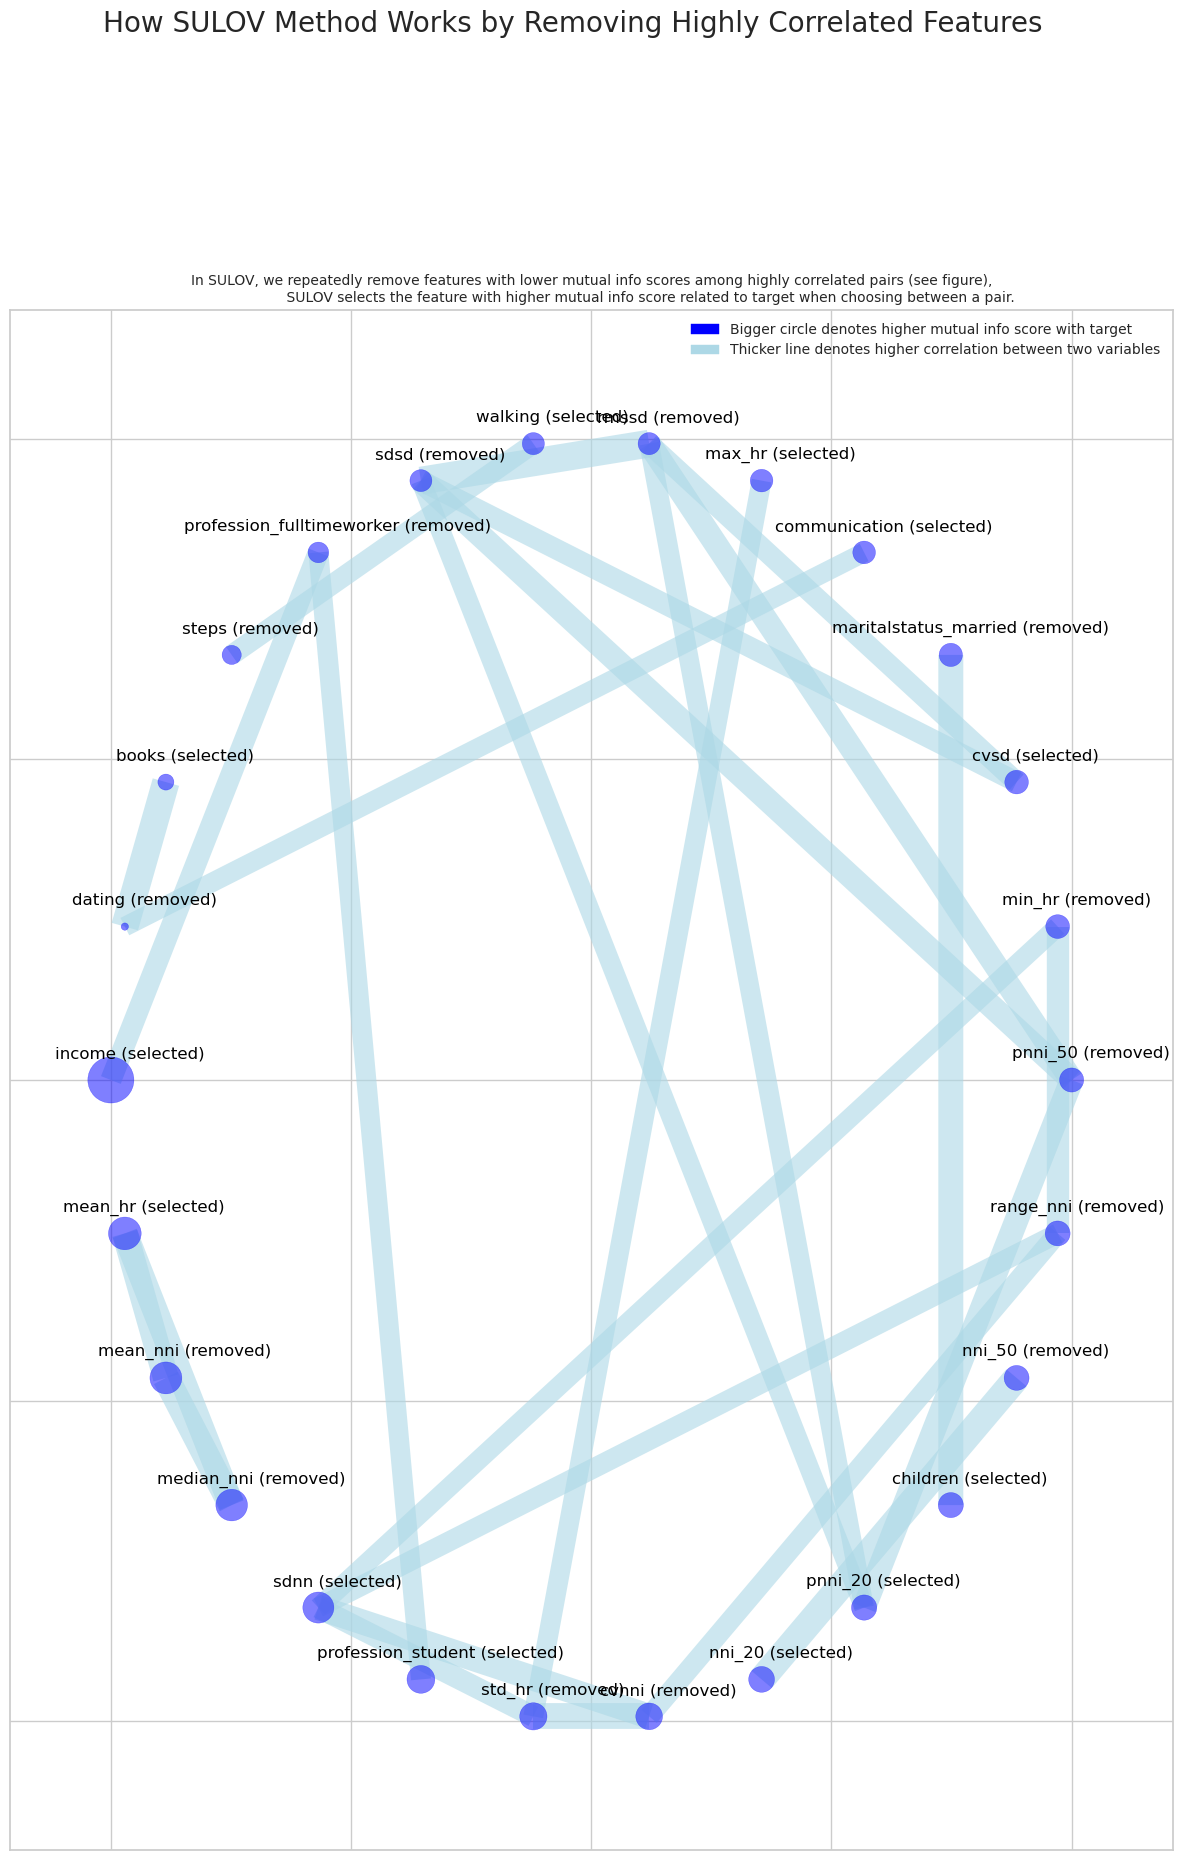

Time taken for SULOV method = 2 seconds
    Adding 1 categorical variables to reduced numeric variables  of 70
Finally 71 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (1373, 72)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 17 features per iteration...
    XGBoost version using 1.7.6 as tree method: hist
    Number of booster rounds = 100
        Selected: ['height', 'income', 'health', 'sdnn', 'social', 'weight', 'communication', 'nni_20', 'specificage', 'other', 'business', 'calories', 'finance', 'video', 'photography', 'productivity', 'walki

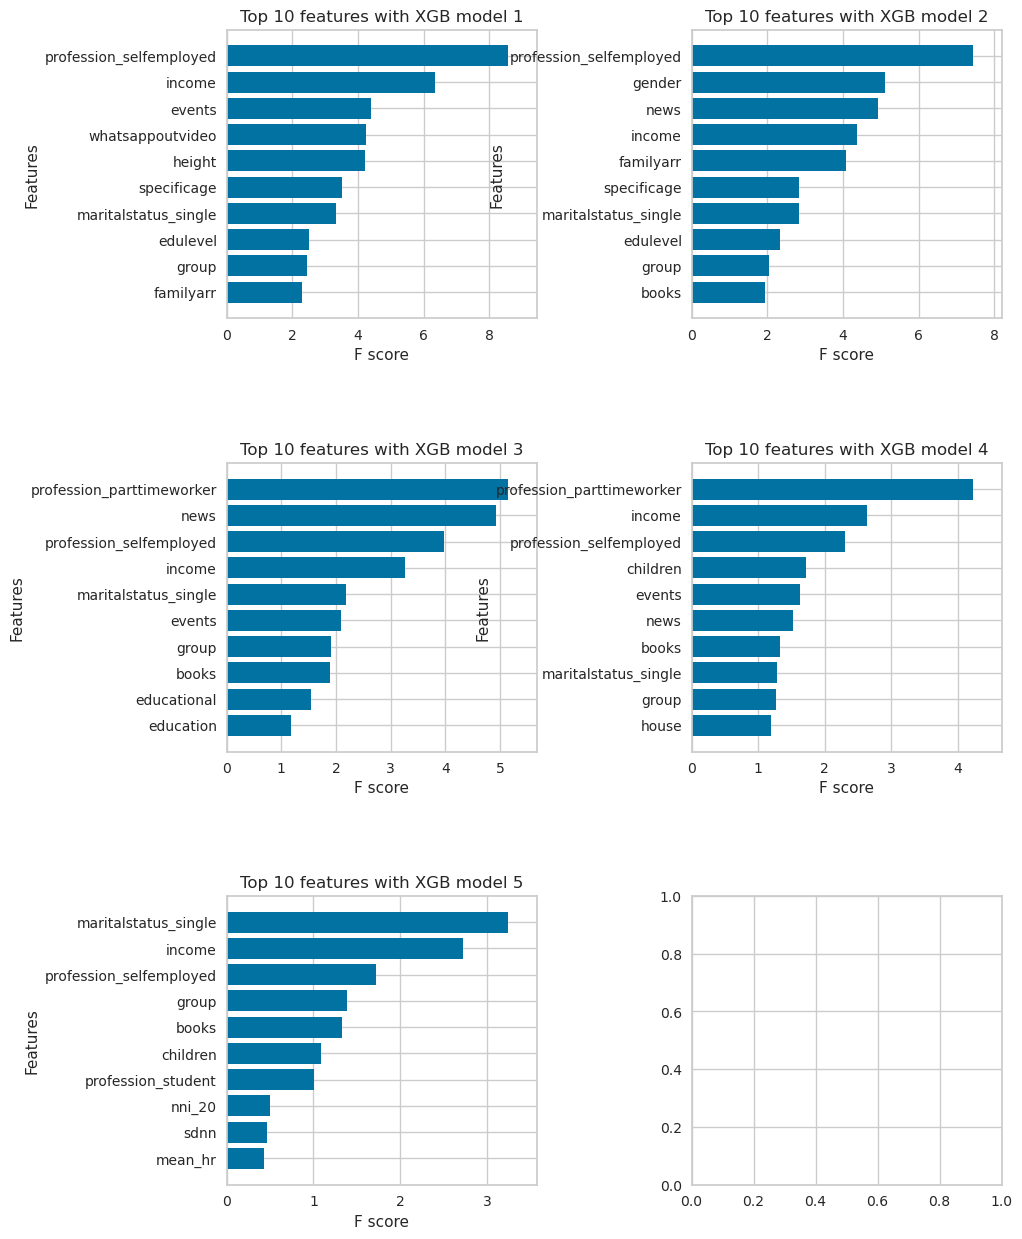

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 34 important features. Too many to print...
Total Time taken for featurewiz selection = 39 seconds
Output contains a list of 34 important features and a train dataframe
['height', 'income', 'health', 'sdnn', 'social', 'weight', 'communication', 'nni_20', 'specificage', 'other', 'business', 'calories', 'finance', 'video', 'photography', 'productivity', 'walking', 'mean_hr', 'familyarr', 'education', 'games', 'music', 'entertainment', 'cvsd', 'group', 'pnni_20', 'max_hr', 'invehicle', 'profession_parttimeworker', 'profession_selfemployed', 'profession_student', 'maritalstatus_single', 'books', 'children']


In [8]:
features, train = featurewiz(df_physical, 'phy_ref_score', corr_limit=0.7, verbose=2, sep=",", header=0, test_data="", feature_engg="", category_encoders="")
print(features)

In [9]:
features = ['height', 'income', 'health', 'sdnn', 'social', 'weight', 'communication', 'nni_20', 'specificage', 'other', 'business', 'calories', 'finance', 'video', 'photography', 'productivity', 'walking', 'mean_hr', 'familyarr', 'education', 'games', 'music', 'entertainment', 'cvsd', 'group', 'pnni_20', 'max_hr', 'invehicle', 'profession_parttimeworker', 'profession_selfemployed', 'profession_student', 'maritalstatus_single', 'books', 'children']

In [10]:
rmsle_cv(get_rforest_phy(), 'phy_all', features)

Time: 287.3162524700165 MAE: 5.7238 RMSE: 8.0686 R^2: 0.7209 



In [11]:
rmsle_cv(get_rforest_phy(), 'phy_all')

TypeError: rmsle_cv() missing 1 required positional argument: 'features'

In [ ]:
rmsle_cv(get_rforest_psy(), 'psy_all')